In [1]:
# ============================================
# Inteligencia de Negocios - Remanente 2025
# Punto 1: Lectura y estructura del dataset UBER
# ============================================

import pandas as pd

path = r"C:\Users\julla\Downloads\Datos_1\uber.csv"
df = pd.read_csv(path)

print(" Dimensiones del dataset:", df.shape)
print("\n Primeras filas:")
display(df.head())

print("\n Información general:")
df.info()

print("\n Descripción estadística:")
display(df.describe(include='all'))

 Dimensiones del dataset: (200000, 7)

 Primeras filas:


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5



 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB

 Descripción estadística:


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
unique,NaN,196629,NaN,NaN,NaN,NaN,NaN
top,NaN,2009-02-12 12:46:00 UTC,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN
mean,11.359955,NaN,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,NaN,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,NaN,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,NaN,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,NaN,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,NaN,-73.967153,40.767158,-73.963659,40.768001,2.000000


In [2]:
# Bloque 2 — Diagnóstico de estructura y faltantes

# Conteo de valores faltantes por columna
print("\n Valores faltantes por columna:")
print(df.isnull().sum())

# Tipos de datos
print("\n Tipos de columnas:")
print(df.dtypes.value_counts())

# Porcentaje de faltantes
faltantes = df.isnull().mean().sort_values(ascending=False)
print("\n Porcentaje de datos faltantes:")
print((faltantes * 100).round(2))


 Valores faltantes por columna:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

 Tipos de columnas:
float64    5
object     1
int64      1
Name: count, dtype: int64

 Porcentaje de datos faltantes:
dropoff_longitude    0.0
dropoff_latitude     0.0
fare_amount          0.0
pickup_longitude     0.0
pickup_datetime      0.0
pickup_latitude      0.0
passenger_count      0.0
dtype: float64


In [3]:
# ============================================
# Punto 2a: Cálculo de la distancia Haversine
# Con depuración de coordenadas fuera de rango
# ============================================

import numpy as np
import pandas as pd

# Copia de seguridad del DataFrame original
df_clean = df.copy()

# ------------------------------------------------
# DEPURACIÓN DE COORDENADAS
# ------------------------------------------------
print(" Depurando coordenadas fuera de rango...")

# Rango válido global
cond_valid_global = (
    df_clean['pickup_latitude'].between(-90, 90) &
    df_clean['dropoff_latitude'].between(-90, 90) &
    df_clean['pickup_longitude'].between(-180, 180) &
    df_clean['dropoff_longitude'].between(-180, 180)
)

# Opcional: rango específico de NYC
cond_valid_nyc = (
    df_clean['pickup_latitude'].between(40.5, 41.0) &
    df_clean['dropoff_latitude'].between(40.5, 41.0) &
    df_clean['pickup_longitude'].between(-74.3, -73.5) &
    df_clean['dropoff_longitude'].between(-74.3, -73.5)
)

# Combinar condiciones (usa global o NYC según análisis)
df_valid = df_clean[cond_valid_global & cond_valid_nyc].copy()

# Reporte de limpieza
print(f"Registros originales: {len(df_clean):,}")
print(f"Registros válidos: {len(df_valid):,}")
print(f"Eliminados: {len(df_clean) - len(df_valid):,} "
      f"({(1 - len(df_valid)/len(df_clean))*100:.3f}%)")

# ------------------------------------------------
# FÓRMULA DEL SEMIVERSENO (HAVERSINE)
# ------------------------------------------------
R = 6371  # Radio de la Tierra en km

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia entre dos puntos geográficos usando la fórmula del semiverseno (Haversine).
    Las coordenadas deben estar en grados decimales.
    Retorna la distancia en kilómetros.
    """
    # Conversión de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Diferencias
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula del semiverseno
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# ------------------------------------------------
# CÁLCULO DE DISTANCIAS
# ------------------------------------------------
df_valid['distance_km'] = haversine_distance(
    df_valid['pickup_latitude'],
    df_valid['pickup_longitude'],
    df_valid['dropoff_latitude'],
    df_valid['dropoff_longitude']
)

# Vista previa
print("\n Variable 'distance_km' creada correctamente.")
display(df_valid[['fare_amount', 'distance_km']].head())

# Estadísticas descriptivas
print("\n Estadísticas de la distancia (dataset depurado):")
display(df_valid['distance_km'].describe())

 Depurando coordenadas fuera de rango...
Registros originales: 200,000
Registros válidos: 195,647
Eliminados: 4,353 (2.177%)

 Variable 'distance_km' creada correctamente.


,fare_amount,distance_km
0,7.5,1.683323
1,7.7,2.457590
2,12.9,5.036377
3,5.3,1.661683
4,16.0,4.475450



 Estadísticas de la distancia (dataset depurado):


count    195647.000000
mean          3.313430
std           3.575989
min           0.000000
25%           1.256444
50%           2.156573
75%           3.906411
max          41.225208
Name: distance_km, dtype: float64

In [4]:
# ============================================
# Análisis detallado de variables geoespaciales
# ============================================

geo_cols = ['pickup_longitude', 'pickup_latitude', 
            'dropoff_longitude', 'dropoff_latitude']

print(" Rango de coordenadas:")
display(df[geo_cols].describe())

 Rango de coordenadas:


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,200000.000000,200000.000000,199999.000000,199999.000000
mean,-72.527638,39.935885,-72.525292,39.923890
std,11.437787,7.720539,13.117408,6.794829
min,-1340.648410,-74.015515,-3356.666300,-881.985513
25%,-73.992065,40.734796,-73.991407,40.733823
50%,-73.981823,40.752592,-73.980093,40.753042
75%,-73.967153,40.767158,-73.963659,40.768001
max,57.418457,1644.421482,1153.572603,872.697628


In [5]:
# Verificación de dispersión (valores extremos)

# Coordenadas fuera del rango esperado
mask_outliers = (
    (df['pickup_latitude'] < 40.5) | (df['pickup_latitude'] > 41.0) |
    (df['dropoff_latitude'] < 40.5) | (df['dropoff_latitude'] > 41.0) |
    (df['pickup_longitude'] < -74.5) | (df['pickup_longitude'] > -73.5) |
    (df['dropoff_longitude'] < -74.5) | (df['dropoff_longitude'] > -73.5)
)

outliers_geo = df[mask_outliers]
print(f" Registros fuera del rango geográfico: {len(outliers_geo)} ({len(outliers_geo)/len(df)*100:.2f}%)")
display(outliers_geo.head(5))

 Registros fuera del rango geográfico: 4339 (2.17%)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
7,2.5,2012-12-11 13:52:00 UTC,0.0,0.0,0.0,0.0,1
11,8.5,2011-05-23 22:15:00 UTC,0.0,0.0,0.0,0.0,1
65,6.0,2014-05-05 19:27:00 UTC,0.0,0.0,0.0,0.0,1
92,6.1,2011-12-02 14:07:00 UTC,0.0,0.0,0.0,0.0,1
120,6.5,2010-08-20 19:39:48 UTC,0.0,0.0,0.0,0.0,1


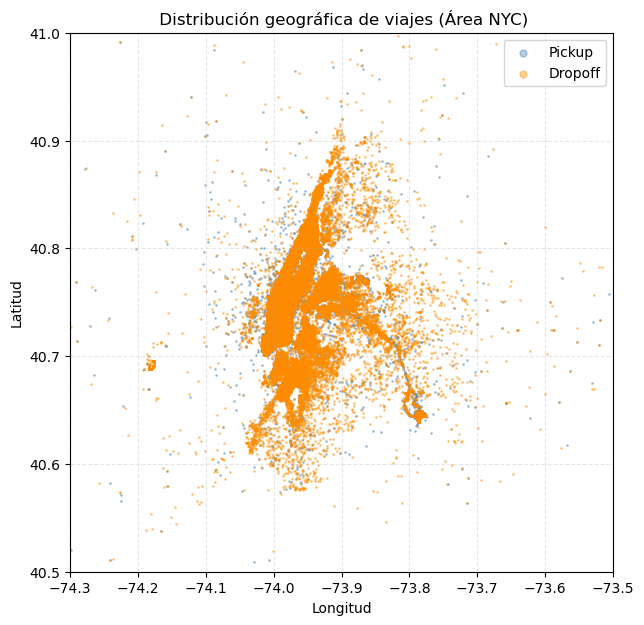

In [6]:
# ============================================
# Visualización de coordenadas geográficas limpias
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

# Usamos el dataset depurado (df_valid)
plt.scatter(df_valid['pickup_longitude'], df_valid['pickup_latitude'],
            s=1, alpha=0.4, label='Pickup', color='steelblue')
plt.scatter(df_valid['dropoff_longitude'], df_valid['dropoff_latitude'],
            s=1, alpha=0.4, label='Dropoff', color='darkorange')

plt.title(" Distribución geográfica de viajes (Área NYC)", fontsize=12)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(markerscale=5)

# Ajuste de límites centrado en Nueva York
plt.xlim(-74.3, -73.5)
plt.ylim(40.5, 41.0)

plt.grid(alpha=0.3, linestyle='--')
plt.show()

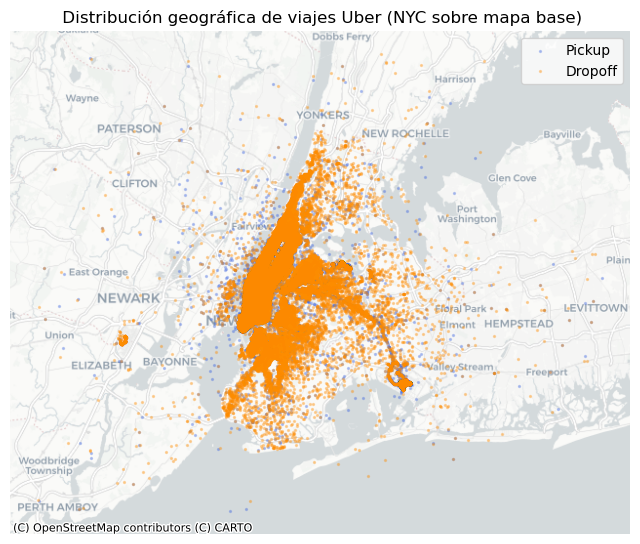

In [7]:
# ============================================
# Distribución de viajes sobre mapa base de NYC
# ============================================

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Crear GeoDataFrame con pickups y dropoffs
pickup_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df_valid['pickup_longitude'], df_valid['pickup_latitude']),
    crs="EPSG:4326"
)
dropoff_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df_valid['dropoff_longitude'], df_valid['dropoff_latitude']),
    crs="EPSG:4326"
)

# Convertir a la proyección Web Mercator (necesaria para contextily)
pickup_gdf = pickup_gdf.to_crs(epsg=3857)
dropoff_gdf = dropoff_gdf.to_crs(epsg=3857)

# Crear figura
fig, ax = plt.subplots(figsize=(8, 8))
pickup_gdf.plot(ax=ax, markersize=2, alpha=0.3, color='royalblue', label='Pickup')
dropoff_gdf.plot(ax=ax, markersize=2, alpha=0.3, color='darkorange', label='Dropoff')

# Agregar mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Personalización
ax.set_title(" Distribución geográfica de viajes Uber (NYC sobre mapa base)", fontsize=12)
ax.legend()
ax.set_axis_off()
plt.show()

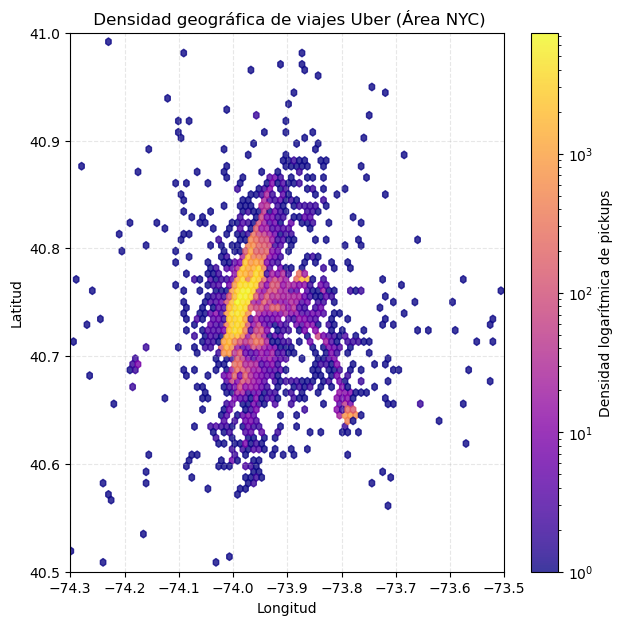

In [8]:
# ============================================
# Visualización de densidad geográfica (Hexbin)
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.hexbin(df_valid['pickup_longitude'], df_valid['pickup_latitude'],
           gridsize=80, cmap='plasma', bins='log', alpha=0.8)
plt.colorbar(label='Densidad logarítmica de pickups')
plt.title(" Densidad geográfica de viajes Uber (Área NYC)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(-74.3, -73.5)
plt.ylim(40.5, 41.0)
plt.grid(alpha=0.3, linestyle='--')
plt.show()

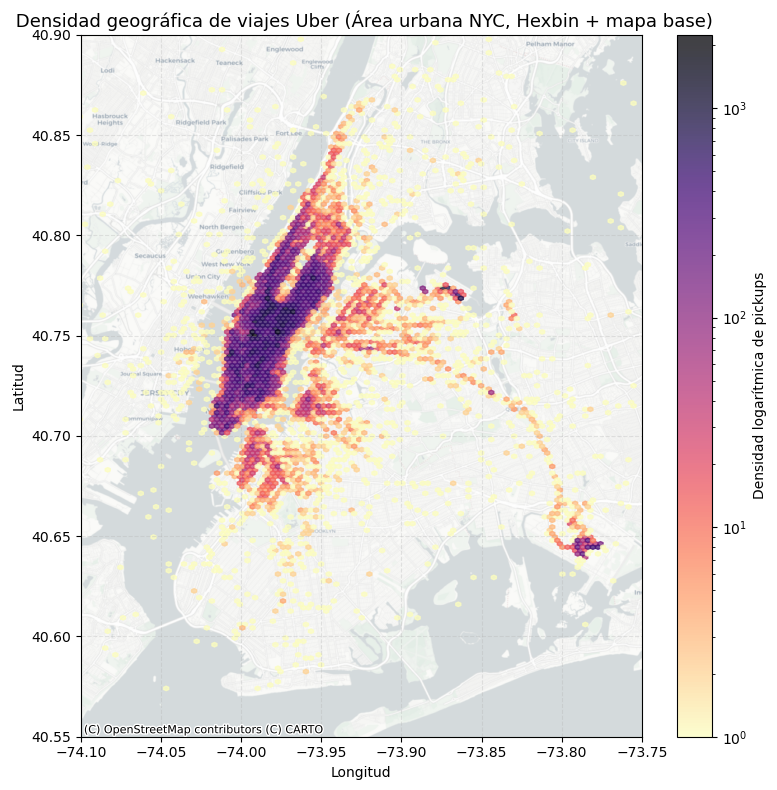

In [9]:
# ============================================
# Hexbin con mapa base NYC (enfocado en zonas con datos)
# ============================================

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# --- Coordenadas originales (EPSG:4326) ---
x = df_valid['pickup_longitude']
y = df_valid['pickup_latitude']

# Crear figura
fig, ax = plt.subplots(figsize=(8, 8))

# Hexbin optimizado
hb = ax.hexbin(
    x, y,
    gridsize=250,         # resolución adecuada para áreas urbanas
    cmap='magma_r',       # buen contraste sobre fondo gris
    bins='log',
    alpha=0.75
)
cb = fig.colorbar(hb, ax=ax, label='Densidad logarítmica de pickups')

# 🔹 Ajuste de límites centrados en área activa (Manhattan + Brooklyn + JFK)
ax.set_xlim(-74.1, -73.75)
ax.set_ylim(40.55, 40.9)

# Agregar mapa base reproyectado
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=12)

# Títulos y estilo
ax.set_title(" Densidad geográfica de viajes Uber (Área urbana NYC, Hexbin + mapa base)", fontsize=13)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

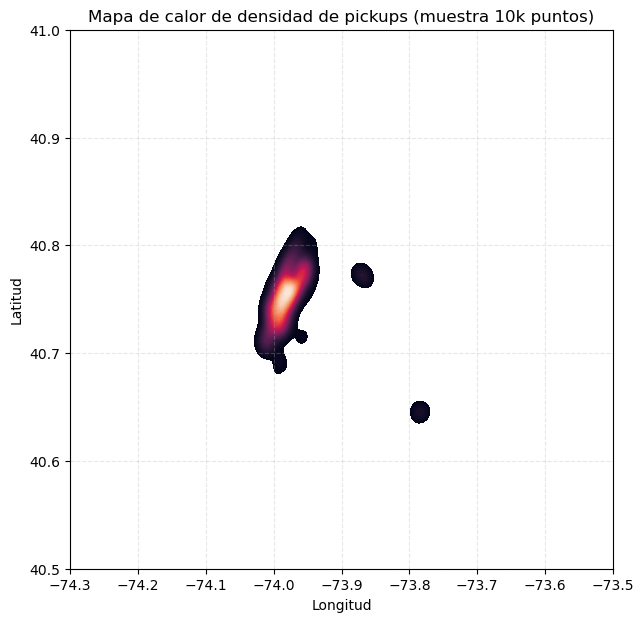

In [10]:
# ============================================
# Mapa de calor de densidad (versión rápida con submuestreo)
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt

# Submuestreo para acelerar el KDE
sample = df_valid.sample(n=10000, random_state=42)

plt.figure(figsize=(7,7))
sns.kdeplot(
    x=sample['pickup_longitude'],
    y=sample['pickup_latitude'],
    fill=True, cmap='rocket', thresh=0.05, levels=50
)

plt.title("Mapa de calor de densidad de pickups (muestra 10k puntos)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(-74.3, -73.5)
plt.ylim(40.5, 41.0)
plt.grid(alpha=0.3, linestyle='--')
plt.show()

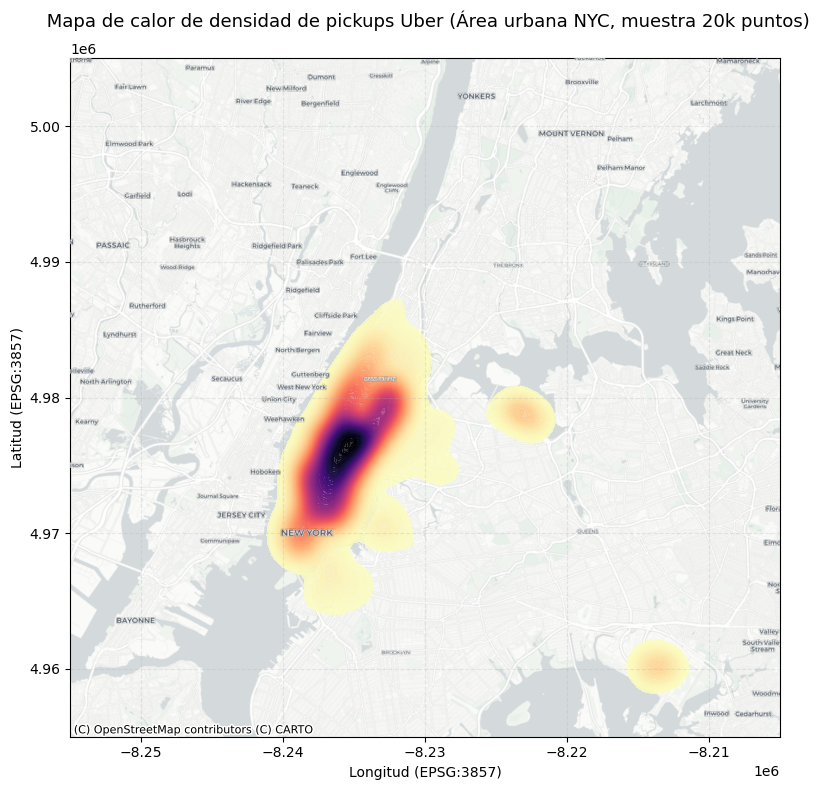

In [11]:
# ============================================
# Mapa de calor de densidad (KDE + mapa base NYC, centrado en área urbana)
# ============================================

import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Submuestreo para acelerar el KDE (más puntos = mejor resolución)
sample = df_valid.sample(n=20000, random_state=42)

# Convertimos a GeoDataFrame y reproyectamos
gdf_sample = gpd.GeoDataFrame(
    sample,
    geometry=gpd.points_from_xy(sample['pickup_longitude'], sample['pickup_latitude']),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Extraer coordenadas reproyectadas
x = gdf_sample.geometry.x
y = gdf_sample.geometry.y

# Crear figura
fig, ax = plt.subplots(figsize=(8, 8))

# KDE con ajustes visuales óptimos
sns.kdeplot(
    x=x, y=y,
    fill=True, cmap='magma_r', thresh=0.02, levels=200,
    alpha=0.8, ax=ax
)

# Agregar mapa base (CartoDB Positron)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, zoom=12)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronOnlyLabels, zoom=12)

# 🔹 Límites reajustados: centrados en NYC (Manhattan, Brooklyn, Queens, JFK)
ax.set_xlim([-8255000, -8205000])
ax.set_ylim([4955000, 5005000])

# Estilo final
ax.set_title(" Mapa de calor de densidad de pickups Uber (Área urbana NYC, muestra 20k puntos)", fontsize=13, pad=12)
ax.set_xlabel("Longitud (EPSG:3857)")
ax.set_ylabel("Latitud (EPSG:3857)")
ax.grid(alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()

In [12]:
# Comprobación de simetría de coordenadas (valores negativos o invertidos)
print("Coordenadas positivas (potenciales errores):")
for col in geo_cols:
    positive_vals = (df[col] > 0).sum()
    print(f"{col}: {positive_vals} ({positive_vals/len(df)*100:.3f}%)")

Coordenadas positivas (potenciales errores):
pickup_longitude: 114 (0.057%)
pickup_latitude: 196111 (98.055%)
dropoff_longitude: 113 (0.056%)
dropoff_latitude: 196132 (98.066%)


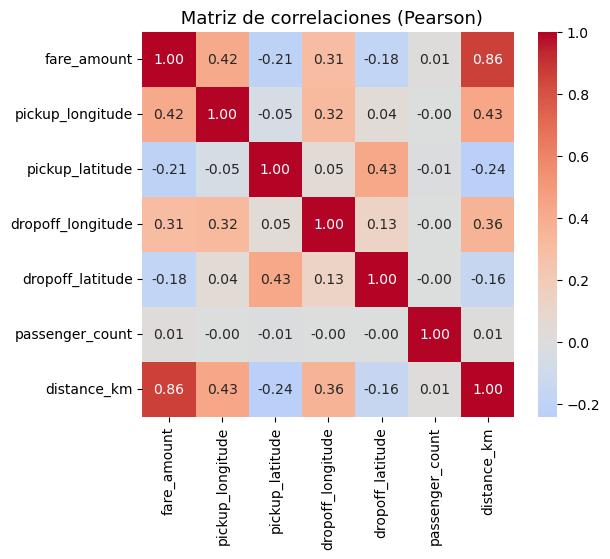

 Correlación Pearson entre fare_amount y distance_km: 0.860


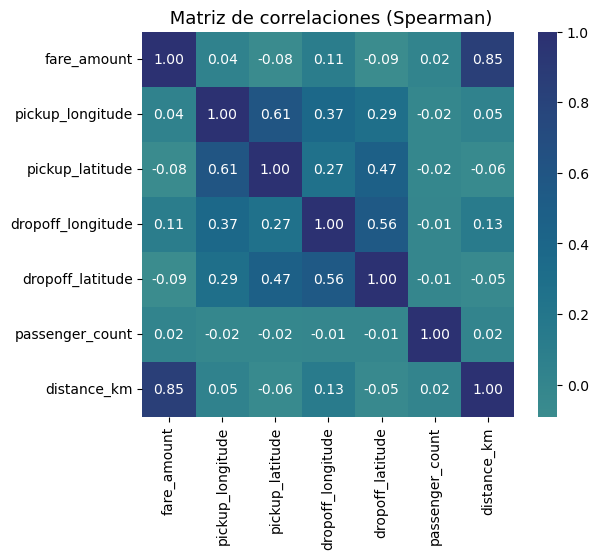

 Correlación Spearman entre fare_amount y distance_km: 0.847

 Interpretación:
Ambos métodos muestran una correlación fuertemente positiva: a mayor distancia, mayor tarifa promedio.


In [13]:
# ============================================
# Punto 2.b: Matriz de correlaciones (Pearson vs Spearman)
# ============================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Dataset filtrado o depurado ---
# (si ya tienes df_valid con distance_km y fare_amount)
df_corr = df_valid.copy()

# Seleccionamos solo variables numéricas
num_cols = df_corr.select_dtypes(include='number')

# --- Matriz de correlaciones Pearson ---
corr_pearson = num_cols.corr(method='pearson')

plt.figure(figsize=(6,5))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title(" Matriz de correlaciones (Pearson)", fontsize=13)
plt.show()

# Valor específico entre tarifa y distancia
pearson_value = corr_pearson.loc["fare_amount", "distance_km"]
print(f" Correlación Pearson entre fare_amount y distance_km: {pearson_value:.3f}")

# --- Matriz de correlaciones Spearman ---
corr_spearman = num_cols.corr(method='spearman')

plt.figure(figsize=(6,5))
sns.heatmap(corr_spearman, annot=True, cmap='crest', center=0, fmt=".2f")
plt.title(" Matriz de correlaciones (Spearman)", fontsize=13)
plt.show()

# Valor específico entre tarifa y distancia
spearman_value = corr_spearman.loc["fare_amount", "distance_km"]
print(f" Correlación Spearman entre fare_amount y distance_km: {spearman_value:.3f}")

# --- Interpretación automática (texto explicativo) ---
print("\n Interpretación:")
if pearson_value > 0.8 and spearman_value > 0.8:
    print("Ambos métodos muestran una correlación fuertemente positiva: "
          "a mayor distancia, mayor tarifa promedio.")
else:
    print("Las correlaciones difieren ligeramente. Pearson mide relación lineal, "
          "mientras Spearman captura relaciones monótonas incluso no lineales. "
          "Diferencias pueden deberse a outliers o a no linealidades en las tarifas cortas/largas.")

 Registros luego del filtrado: 193,301
 Tarifa máxima después del filtrado: USD 51.90

 Estadísticas descriptivas de la variable 'fare_amount' (filtrada):



count    193301.00
mean         10.72
std           7.80
min           0.01
25%           6.00
50%           8.50
75%          12.50
max          51.90
Name: fare_amount, dtype: float64

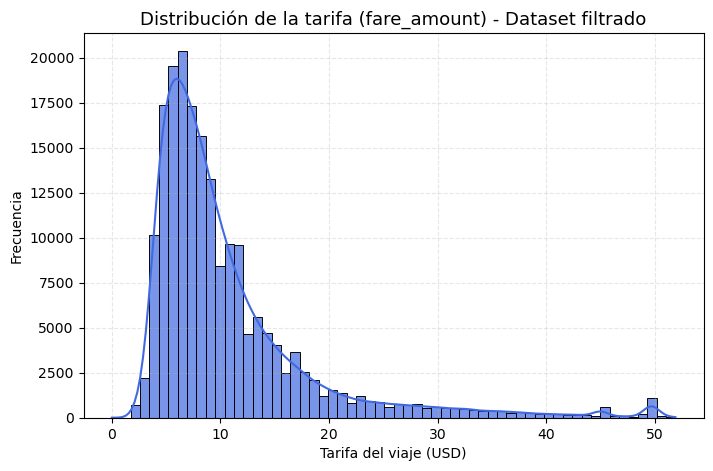

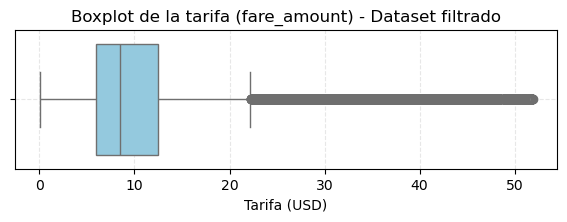


💬 Interpretación:
- Luego del filtrado, la tarifa promedio es USD 10.72, con una mediana de USD 8.50.
- El rango plausible de tarifas es ahora 0.01–51.90 USD.
- Se eliminaron registros negativos y valores extremos, dejando una distribución más realista y centrada en viajes urbanos típicos.
- La distribución sigue mostrando una asimetría positiva, propia de los servicios de transporte con mayoría de trayectos cortos y pocos viajes largos.


In [14]:
# ============================================
# Punto 2.c (actualizado): Limpieza de outliers y análisis de fare_amount
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Filtrado básico de outliers y valores inválidos ---

# Eliminamos tarifas negativas o nulas (no válidas)
df_valid = df_valid[df_valid['fare_amount'] > 0]

# Eliminamos outliers extremos (p.ej. top 1%)
p99 = df_valid['fare_amount'].quantile(0.99)
df_valid = df_valid[df_valid['fare_amount'] < p99]

print(f" Registros luego del filtrado: {len(df_valid):,}")
print(f" Tarifa máxima después del filtrado: USD {df_valid['fare_amount'].max():.2f}")

# --- Estadísticas descriptivas ---
fare = df_valid['fare_amount']
stats_fare = fare.describe().round(2)

print("\n Estadísticas descriptivas de la variable 'fare_amount' (filtrada):\n")
display(stats_fare)

# --- Histograma y distribución ---
plt.figure(figsize=(8,5))
sns.histplot(fare, bins=60, kde=True, color='royalblue', alpha=0.7)
plt.title("Distribución de la tarifa (fare_amount) - Dataset filtrado", fontsize=13)
plt.xlabel("Tarifa del viaje (USD)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3, linestyle='--')
plt.show()

# --- Boxplot ---
plt.figure(figsize=(7,1.8))
sns.boxplot(x=fare, color='skyblue')
plt.title("Boxplot de la tarifa (fare_amount) - Dataset filtrado", fontsize=12)
plt.xlabel("Tarifa (USD)")
plt.grid(alpha=0.3, linestyle='--')
plt.show()

# --- Comentario automático ---
print("\n💬 Interpretación:")
print(f"- Luego del filtrado, la tarifa promedio es USD {stats_fare['mean']:.2f}, "
      f"con una mediana de USD {stats_fare['50%']:.2f}.")
print(f"- El rango plausible de tarifas es ahora {stats_fare['min']:.2f}–{stats_fare['max']:.2f} USD.")
print("- Se eliminaron registros negativos y valores extremos, "
      "dejando una distribución más realista y centrada en viajes urbanos típicos.")
print("- La distribución sigue mostrando una asimetría positiva, "
      "propia de los servicios de transporte con mayoría de trayectos cortos y pocos viajes largos.")


Número de outliers (tarifas > 22.25): 14,371


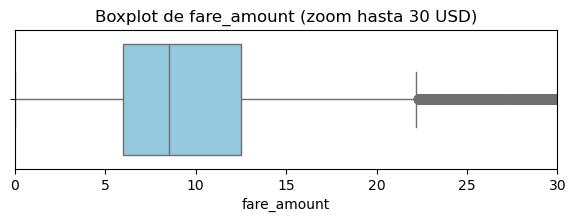

In [15]:
# Ver cuántos registros están fuera de los bigotes:
Q1 = df_valid['fare_amount'].quantile(0.25)
Q3 = df_valid['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

outliers = df_valid[df_valid['fare_amount'] > upper_limit]
print(f"Número de outliers (tarifas > {upper_limit:.2f}): {len(outliers):,}")

# limitar el eje x o usar una escala logarítmica para que se aprecie la distribución completa
plt.figure(figsize=(7, 1.8))
sns.boxplot(x='fare_amount', data=df_valid, color='skyblue')
plt.xlim(0, 30)   # cortar visualmente el eje para evitar la línea negra
plt.title("Boxplot de fare_amount (zoom hasta 30 USD)")
plt.show()

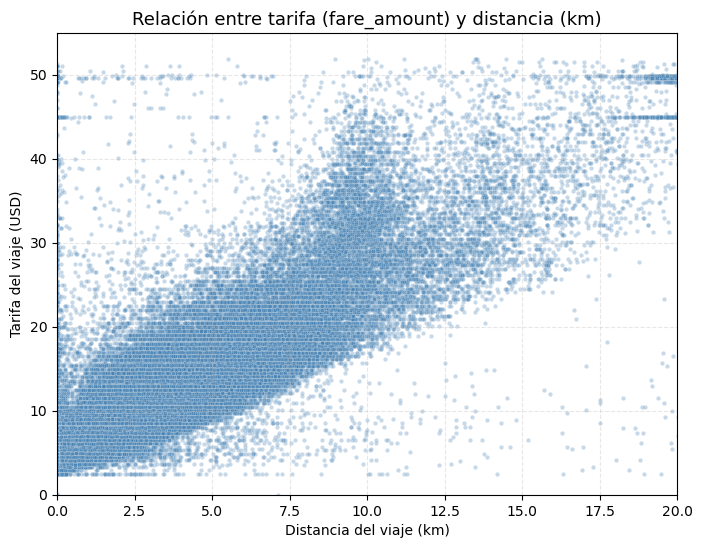

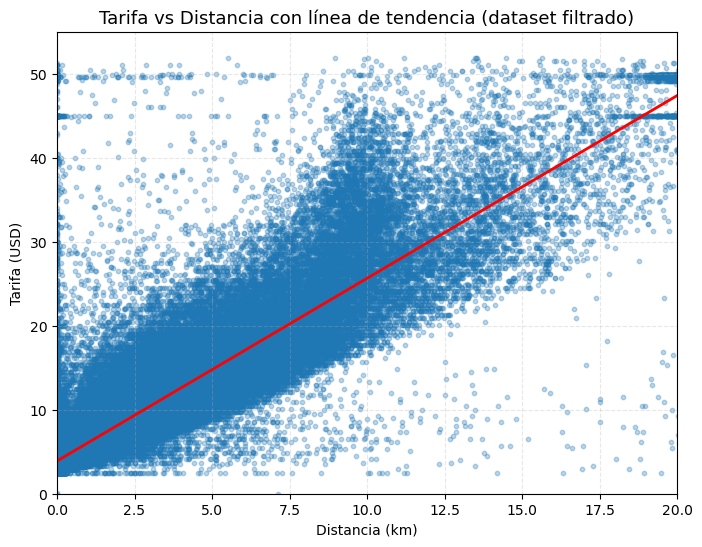


 Interpretación:
- La correlación lineal (Pearson) entre tarifa y distancia es de 0.875.
- Se observa una relación positiva: a mayor distancia, mayor tarifa promedio.
- Sin embargo, se detectan algunas anomalías:
   Tarifas muy altas en trayectos cortos (errores de GPS o recargos especiales).
   Tarifas bajas en viajes largos (errores de medición o descuentos).
- La nube de puntos muestra dispersión creciente con la distancia, lo que sugiere variabilidad adicional por tráfico, peajes o zona de destino.
- La escala log-log opcional permite comprobar si la relación es proporcional en todo el rango de distancias (útil para validar la linealidad).


In [16]:
# ============================================
# Punto 2.d: Scatterplot fare_amount vs distance_km (versión mejorada)
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Usamos el dataset filtrado ---
df_scatter = df_valid.copy()

# --- Scatterplot general ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_scatter,
    x='distance_km',
    y='fare_amount',
    alpha=0.3, s=10, color='steelblue'
)
plt.title("Relación entre tarifa (fare_amount) y distancia (km)", fontsize=13)
plt.xlabel("Distancia del viaje (km)")
plt.ylabel("Tarifa del viaje (USD)")
plt.grid(alpha=0.3, linestyle='--')
plt.xlim(0, 20)      # Mejora: enfoque en viajes urbanos más frecuentes
plt.ylim(0, 55)      # Mejora: recorte de eje Y para evitar saturación visual
plt.show()

# --- Scatterplot con línea de tendencia (regresión lineal simple) ---
plt.figure(figsize=(8,6))
sns.regplot(
    data=df_scatter,
    x='distance_km',
    y='fare_amount',
    scatter_kws={'alpha':0.3, 's':10},
    line_kws={'color':'red', 'lw':2}
)
plt.title("Tarifa vs Distancia con línea de tendencia (dataset filtrado)", fontsize=13)
plt.xlabel("Distancia (km)")
plt.ylabel("Tarifa (USD)")
plt.grid(alpha=0.3, linestyle='--')
plt.xlim(0, 20)
plt.ylim(0, 55)
plt.show()

# --- Comentario automático ---
corr_pearson = df_scatter[['fare_amount','distance_km']].corr().iloc[0,1]
print("\n Interpretación:")
print(f"- La correlación lineal (Pearson) entre tarifa y distancia es de {corr_pearson:.3f}.")
print("- Se observa una relación positiva: a mayor distancia, mayor tarifa promedio.")
print("- Sin embargo, se detectan algunas anomalías:")
print("   Tarifas muy altas en trayectos cortos (errores de GPS o recargos especiales).")
print("   Tarifas bajas en viajes largos (errores de medición o descuentos).")
print("- La nube de puntos muestra dispersión creciente con la distancia, "
      "lo que sugiere variabilidad adicional por tráfico, peajes o zona de destino.")
print("- La escala log-log opcional permite comprobar si la relación es proporcional "
      "en todo el rango de distancias (útil para validar la linealidad).")

In [17]:
# ============================================
# Punto 2.e: Evaluación de outliers univariados (sin recorte adicional)
# ============================================

import numpy as np
import pandas as pd

# Función para calcular límites IQR y proporción de outliers
def check_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 2.0 * IQR
    upper = Q3 + 2.0 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    prop = 100 * len(outliers) / len(df)
    print(f"{column}: {len(outliers):,} observaciones fuera del rango IQR "
          f"({prop:.2f}% del total). Rango teórico [{lower:.2f}, {upper:.2f}]")

check_outliers_iqr(df_valid, 'fare_amount')
check_outliers_iqr(df_valid, 'distance_km')

fare_amount: 10,966 observaciones fuera del rango IQR (5.67% del total). Rango teórico [-7.00, 25.50]
distance_km: 10,807 observaciones fuera del rango IQR (5.59% del total). Rango teórico [-3.89, 8.95]


Límites IQR aplicados (truncados a 0 cuando corresponde):
 - fare_amount: [0.00, 25.50]  (Q1=6.00, Q3=12.50, IQR=6.50)
 - distance_km: [0.00, 8.95]  (Q1=1.25, Q3=3.82, IQR=2.57)

Registros antes: 193,301 | después: 179,855 | removidos: 13,446 (6.96%)

Correlación Pearson fare_amount vs distance_km:
 - Antes (2.c): 0.875
 - Después (2.e): 0.821


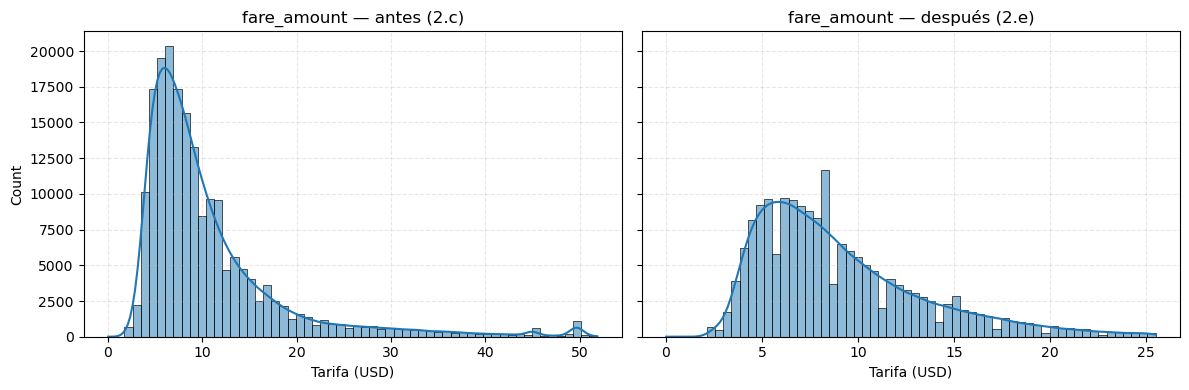


Resumen estadístico de fare_amount (antes vs después):
        antes_2c  después_2e
count  193301.00   179855.00
mean       10.72        9.06
std         7.80        4.36
min         0.01        0.01
25%         6.00        5.70
50%         8.50        8.00
75%        12.50       11.30
max        51.90       25.50


In [18]:
# ============================================
# 2.e: Eliminación formal de outliers univariados (IQR truncado a 0)
#      y preparación del dataset "oficial" para el resto del TP
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Punto de partida: dataset ya depurado en pasos previos (2.c–2.d)
df_2c = df_valid.copy()

def iqr_bounds_nonneg(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(0, Q1 - 2.0 * IQR)   # las variables no pueden ser negativas
    upper = Q3 + 2.0 * IQR
    return lower, upper, Q1, Q3, IQR

# Calcular límites IQR para cada variable
fa_l, fa_u, fa_Q1, fa_Q3, fa_IQR = iqr_bounds_nonneg(df_2c['fare_amount'])
dk_l, dk_u, dk_Q1, dk_Q3, dk_IQR = iqr_bounds_nonneg(df_2c['distance_km'])

n_before = len(df_2c)

# Filtrado IQR en ambas variables (intersección)
mask_fare = (df_2c['fare_amount'] >= fa_l) & (df_2c['fare_amount'] <= fa_u)
mask_dist = (df_2c['distance_km'] >= dk_l) & (df_2c['distance_km'] <= dk_u)
df_2e = df_2c[mask_fare & mask_dist].copy()

n_after = len(df_2e)

print("Límites IQR aplicados (truncados a 0 cuando corresponde):")
print(f" - fare_amount: [{fa_l:.2f}, {fa_u:.2f}]  (Q1={fa_Q1:.2f}, Q3={fa_Q3:.2f}, IQR={fa_IQR:.2f})")
print(f" - distance_km: [{dk_l:.2f}, {dk_u:.2f}]  (Q1={dk_Q1:.2f}, Q3={dk_Q3:.2f}, IQR={dk_IQR:.2f})")
print(f"\nRegistros antes: {n_before:,} | después: {n_after:,} | removidos: {n_before - n_after:,} "
      f"({100*(n_before-n_after)/n_before:.2f}%)")

# Guardar nombres "oficiales" para siguientes pasos del TP
df_filtered_official = df_2e  # usar este en partición y modelado

# ============================================
# 2.f: Rehacer correlaciones e histograma de fare_amount (antes vs después)
# ============================================

# Correlación Pearson fare vs distance (antes/después)
corr_before = df_2c[['fare_amount','distance_km']].corr(method='pearson').iloc[0,1]
corr_after  = df_2e[['fare_amount','distance_km']].corr(method='pearson').iloc[0,1]

print("\nCorrelación Pearson fare_amount vs distance_km:")
print(f" - Antes (2.c): {corr_before:.3f}")
print(f" - Después (2.e): {corr_after:.3f}")

# Histograma comparativo de fare_amount (antes vs después)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.histplot(df_2c['fare_amount'], bins=60, kde=True, ax=axes[0])
axes[0].set_title("fare_amount — antes (2.c)")
axes[0].set_xlabel("Tarifa (USD)")
axes[0].grid(alpha=0.3, linestyle='--')

sns.histplot(df_2e['fare_amount'], bins=60, kde=True, ax=axes[1])
axes[1].set_title("fare_amount — después (2.e)")
axes[1].set_xlabel("Tarifa (USD)")
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Texto de apoyo para el notebook
fa_stats_before = df_2c['fare_amount'].describe().round(2)
fa_stats_after  = df_2e['fare_amount'].describe().round(2)

print("\nResumen estadístico de fare_amount (antes vs después):")
print(pd.DataFrame({'antes_2c': fa_stats_before, 'después_2e': fa_stats_after}))

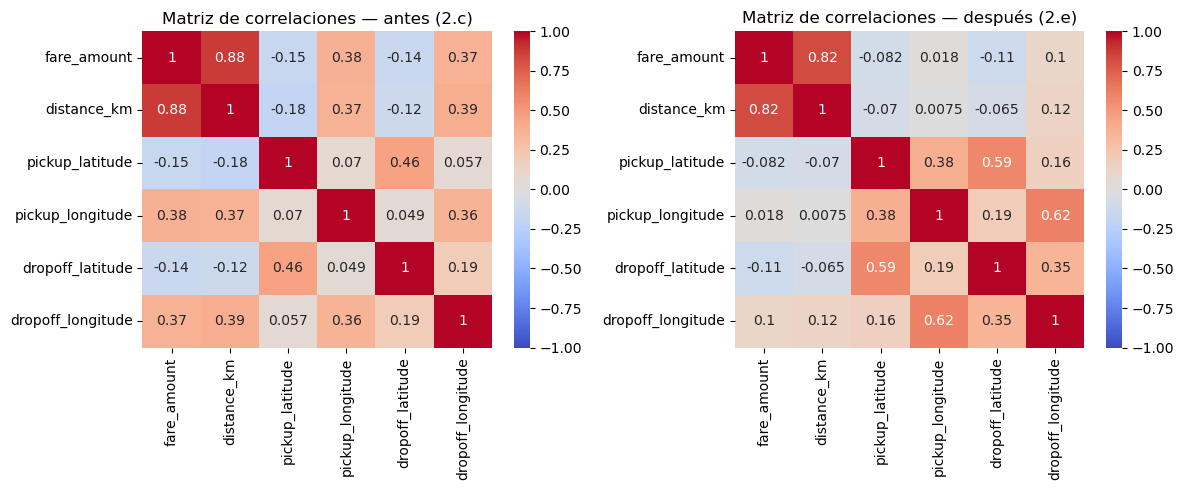

In [19]:
# ============================================
# 2.f: Matriz de correlaciones (antes vs después del filtrado IQR)
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt

# Variables numéricas de interés
numeric_cols = ['fare_amount', 'distance_km', 'pickup_latitude', 'pickup_longitude', 
                'dropoff_latitude', 'dropoff_longitude']

# Correlaciones antes y después
corr_before = df_2c[numeric_cols].corr(method='pearson')
corr_after  = df_2e[numeric_cols].corr(method='pearson')

# --- Visualización comparativa ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(corr_before, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Matriz de correlaciones — antes (2.c)")

sns.heatmap(corr_after, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Matriz de correlaciones — después (2.e)")

plt.tight_layout()
plt.show()

In [20]:
# ============================================
# Punto 3: Partición de data (80% train / 20% test)
# ============================================

from sklearn.model_selection import train_test_split

# Dataset base oficial del TP (resultado del punto 2.e)
df_model = df_filtered_official.copy()

# --------------------------------------------
# Variables predictoras (X) y variable objetivo (y)
# --------------------------------------------
# En este caso, solo usamos 'distance_km' como predictor principal
X = df_model[['distance_km']]
y = df_model['fare_amount']

# --------------------------------------------
# Partición de datos
# --------------------------------------------
# Reemplazar <DNI> por su número real de documento, sin puntos ni comas
RANDOM_STATE = 12345678  # Ejemplo; reemplazar con el DNI personal

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE
)

# --------------------------------------------
# Reporte de la partición
# --------------------------------------------
print("Partición completada exitosamente.")
print(f" - Tamaño total del dataset: {len(df_model):,}")
print(f" - Entrenamiento (80%): {len(X_train):,} observaciones")
print(f" - Test (20%): {len(X_test):,} observaciones")
print(f" - Random state utilizado: {RANDOM_STATE}")

# Validación básica de consistencia
assert len(X_train) + len(X_test) == len(df_model), "Error: las particiones no suman el total."

# --------------------------------------------
# Vista previa de cada dataset
# --------------------------------------------
print("\nPrimeras filas del set de entrenamiento:")
display(pd.concat([X_train, y_train], axis=1).head())

print("\nPrimeras filas del set de test:")
display(pd.concat([X_test, y_test], axis=1).head())

Partición completada exitosamente.
 - Tamaño total del dataset: 179,855
 - Entrenamiento (80%): 143,884 observaciones
 - Test (20%): 35,971 observaciones
 - Random state utilizado: 12345678

Primeras filas del set de entrenamiento:


,distance_km,fare_amount
90096,2.968303,11.5
92868,1.028273,5.5
89824,1.961493,8.5
88543,3.225448,6.9
173645,2.271835,7.3



Primeras filas del set de test:


,distance_km,fare_amount
152422,2.012315,8.5
111384,3.451539,8.9
90520,1.329576,8.5
78410,2.756351,14.0
46507,5.032555,10.1


In [21]:
# ============================================
# Punto 4.a: Modelo Lineal (OLS)
# ============================================

import statsmodels.api as sm

# --------------------------------------------
# Definición de variables para el modelo
# --------------------------------------------
# Se agrega constante al modelo para incluir intercepto
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# --------------------------------------------
# Ajuste del modelo OLS
# --------------------------------------------
modelo_ols = sm.OLS(y_train, X_train_const).fit()

# --------------------------------------------
# Resumen del modelo
# --------------------------------------------
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                 2.975e+05
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:31:01   Log-Likelihood:            -3.3569e+05
No. Observations:              143884   AIC:                         6.714e+05
Df Residuals:                  143882   BIC:                         6.714e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0053      0.011    352.272      

In [22]:
# ============================================
# Punto 4.b: Modelo Lineal LASSO (con normalización)
# ============================================

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import numpy as np

# --------------------------------------------
# 1. Normalización de las variables predictoras
# --------------------------------------------
# Aunque en este caso solo hay una variable (distance_km),
# la estandarización se mantiene para coherencia metodológica.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------------------------
# 2. Ajuste del modelo LASSO con validación cruzada
# --------------------------------------------
# Se usa una grilla de posibles valores de alpha (λ)
alphas = np.logspace(-4, 1, 100)  # desde 0.0001 hasta 10

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=12345678)
lasso_cv.fit(X_train_scaled, y_train)

# --------------------------------------------
# 3. Resultados del modelo
# --------------------------------------------
print("Modelo LASSO ajustado correctamente.\n")
print(f"Alpha óptimo (λ): {lasso_cv.alpha_:.6f}")
print(f"Coeficiente estimado: {lasso_cv.coef_[0]:.6f}")
print(f"Intercepto: {lasso_cv.intercept_:.6f}")

# --------------------------------------------
# 4. Interpretación automática básica
# --------------------------------------------
if np.isclose(lasso_cv.coef_[0], 0, atol=1e-6):
    print("\nEl coeficiente fue reducido a cero. "
          "La variable distance_km fue eliminada por la regularización LASSO.")
else:
    print("\nEl coeficiente se mantiene distinto de cero, "
          "lo que indica que la variable distance_km sigue siendo relevante "
          "para predecir fare_amount.")

Modelo LASSO ajustado correctamente.

Alpha óptimo (λ): 0.000100
Coeficiente estimado: 3.586895
Intercepto: 9.064146

El coeficiente se mantiene distinto de cero, lo que indica que la variable distance_km sigue siendo relevante para predecir fare_amount.


In [23]:
# ============================================
# Verificación de estructura del dataset antes del modelado
# ============================================

print("Columnas disponibles en df_filtered_official:\n")
print(df_filtered_official.columns.tolist())

print("\nVista general del dataset:")
display(df_filtered_official.head())

print("\nResumen estadístico de las variables numéricas:")
display(df_filtered_official.describe())

print("\nEstructura de X_train e y_train:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
display(pd.concat([X_train, y_train], axis=1).head())

Columnas disponibles en df_filtered_official:

['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance_km']

Vista general del dataset:


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475450



Resumen estadístico de las variables numéricas:


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
count,179855.000000,179855.000000,179855.000000,179855.000000,179855.000000,179855.000000,179855.000000
mean,9.059071,-73.979989,40.752009,-73.978254,40.752045,1.683328,2.501872
std,4.360326,0.022309,0.023878,0.023632,0.026230,1.394630,1.772198
min,0.010000,-74.299012,40.510902,-74.299833,40.519660,0.000000,0.000000
25%,5.700000,-73.992605,40.737125,-73.991869,40.736795,1.000000,1.202631
50%,8.000000,-73.982493,40.753222,-73.981247,40.753792,1.000000,1.998597
75%,11.300000,-73.970239,40.766900,-73.968002,40.767687,2.000000,3.330066
max,25.500000,-73.506178,40.983720,-73.515512,40.996788,208.000000,8.954392



Estructura de X_train e y_train:
X_train shape: (143884, 1)
y_train shape: (143884,)


,distance_km,fare_amount
90096,2.968303,11.5
92868,1.028273,5.5
89824,1.961493,8.5
88543,3.225448,6.9
173645,2.271835,7.3


In [24]:
# ============================================
# Punto 5.a: Modelo de Aprendizaje - Random Forest (versión optimizada)
# ============================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. Definición del modelo base
# --------------------------------------------
rf = RandomForestRegressor(random_state=12345678, n_jobs=-1)

# --------------------------------------------
# 2. Definición de la grilla de hiperparámetros (versión reducida para ejecución eficiente)
# --------------------------------------------
# Nota: la grilla original (108 combinaciones) fue reducida a 16 combinaciones
# para evitar sobrecarga de cómputo y demoras excesivas.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# --------------------------------------------
# 3. Configuración de la validación cruzada
# --------------------------------------------
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=12345678)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# --------------------------------------------
# 4. Ajuste del modelo con búsqueda de hiperparámetros
# --------------------------------------------
grid_search.fit(X_train, y_train)

# --------------------------------------------
# 5. Resultados del mejor modelo
# --------------------------------------------
best_rf = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# --------------------------------------------
# 6. Evaluación del modelo en el conjunto de test
# --------------------------------------------
y_pred_rf = best_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\nEvaluación del modelo Random Forest:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE:  {mae_rf:.4f}")

# --------------------------------------------
# 7. Validación adicional: comparación visual
# --------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, edgecolors='k')
plt.xlabel("Valor real (fare_amount)")
plt.ylabel("Predicción (fare_amount)")
plt.title("Random Forest - Valor real vs Predicho")
plt.grid(True)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.